# Задача: по показателям социальной напряженности в субъектах Российской Федерации провести регрессионный анализ

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy.stats import spearmanr


#### В качестве результативного признака Y выступает «Ожидаемая продолжительность жизни граждан», выраженная в годах, а в качестве объясняющих признаков X1…X9 выступают:

In [2]:
variables = pd.DataFrame(pd.read_excel('эконометрика.xlsx', sheet_name='Лист2'))
variables

,Переменная,Наименование переменной
0,Y,Продолжительность жизни граждан
1,X1,"Коэффициент смертности,%"
2,X2,Соотношение браков и разводов (на 1000 браков ...
3,X3,Потребительские расходы в среднем на душу насе...
4,X4,"Уровень занятости женщин, имеющих детей дошко..."
5,X5,"Реальные денежные доходы населения, в % к пред..."
6,X6,Численность населения с денежными доходами ниж...
7,X7,"Общая площадь жилых помещений, приходящаяся в ..."
8,X8,Численность населения на одну больничную койку
9,X9,Заболеваемость на 1000 человек населения


In [3]:
data = pd.DataFrame(pd.read_excel("эконометрика.xlsx", engine="openpyxl", sheet_name='TEST'))
data.head()

,Наименование,Y,X1,X2,X3,X4,X5,X6,X7,X8
0,Алтайский край,70.77,780,28083,67.3,103.3,13.3,28.4,104.42,1041.5
1,Амурская область,68.25,837,40104,66.9,99.9,11.8,28.1,107.54,885.8
2,Архангельская область без автономного округа,71.54,727,43161,72.0,105.9,9.0,34.2,108.79,1127.1
3,Астраханская область,72.20,1006,29728,66.2,103.7,12.0,27.9,119.02,702.1
4,Белгородская область,73.70,629,35281,77.8,105.2,5.6,36.0,140.00,766.2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Наименование  85 non-null     object 
 1   Y             85 non-null     float64
 2   X1            85 non-null     int64  
 3   X2            85 non-null     int64  
 4   X3            85 non-null     float64
 5   X4            85 non-null     float64
 6   X5            85 non-null     float64
 7   X6            85 non-null     float64
 8   X7            85 non-null     float64
 9   X8            85 non-null     float64
dtypes: float64(7), int64(2), object(1)
memory usage: 6.8+ KB


In [5]:
data.describe()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,72.422118,835.070588,35632.211765,68.137647,106.092941,10.771765,29.180000,124.860235,839.360000
std,2.606545,452.605020,9794.798333,9.810356,3.263390,4.103762,4.608398,23.623865,198.924828
min,66.560000,77.000000,14491.000000,17.900000,99.900000,3.600000,15.300000,74.230000,428.300000
25%,70.670000,700.000000,29757.000000,63.200000,103.700000,8.500000,26.600000,108.830000,702.100000
50%,72.150000,733.000000,32507.000000,69.600000,105.900000,10.200000,29.600000,122.320000,808.500000
75%,73.700000,793.000000,40630.000000,75.500000,107.800000,12.500000,32.600000,133.730000,922.700000
max,79.870000,3528.000000,78051.000000,82.400000,115.600000,27.700000,37.900000,225.600000,1505.900000


### По исходным статистическим данным найдем оценки коэффициентов уравнения регрессии 
#### Для этого создаем и обучаем модель МНК

In [6]:
Y = data['Y']
X = data[data.columns[2:11]]

X = sm.add_constant(X)
model = sm.OLS(Y,X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     18.92
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           2.71e-15
Time:                        21:52:10   Log-Likelihood:                -154.97
No. Observations:                  85   AIC:                             327.9
Df Residuals:                      76   BIC:                             349.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.2532      6.702     10.185      0.0

#### Проверяем уравнение на значимость по значению p-value для F-статистики

In [7]:
f_pvalue = res.f_pvalue
p = 0.05

print("Уравнение значимо" if f_pvalue < p else "Уравнение незначимо")

Уравнение значимо


#### Получаем оценку уравнения регрессии:


In [8]:
coefficients = pd.DataFrame(res.params)

equation = f"Y = {coefficients.loc['const',0]:.4f}"

for name, coef in coefficients[1:].iterrows():
    x = name
    i = coef[0]
    sign = "+" if i >= 0 else "-"
    equation += f" {sign} {abs(i):.6f}*{x}"


print("Уравнение регрессии:")
print(equation)

Уравнение регрессии:
Y = 68.2532 + 0.002401*X1 + 0.000006*X2 - 0.032028*X3 + 0.039381*X4 - 0.306310*X5 - 0.056461*X6 + 0.052854*X7 - 0.002021*X8


#### Проверяем гипотезы о значимости коэффициентов ЛММР:

In [9]:
alpha = 0.05
df = len(data) - len(variables[1:]) - 1
t_kr = stats.t.ppf(1 - alpha/2, df)

t_stat = res.tvalues
p_value = res.pvalues

results_st = pd.DataFrame({
    'Коэффициент': t_stat.index,
    't-статистика': t_stat.values,
    'p-value': p_value.values,
    'Значимость': ['значим' if abs(t_stat[i]) > t_kr and p_value[i] < alpha else 'не значим'
                   for i in range(len(t_stat))]
})

print(results_st)

  Коэффициент  t-статистика       p-value Значимость
0       const     10.184727  7.429010e-16     значим
1          X1      4.289185  5.213123e-05     значим
2          X2      0.224106  8.232765e-01  не значим
3          X3     -1.573900  1.196645e-01  не значим
4          X4      0.711886  4.787148e-01  не значим
5          X5     -4.003761  1.438374e-04     значим
6          X6     -1.142571  2.568034e-01  не значим
7          X7      5.874023  1.056502e-07     значим
8          X8     -2.065790  4.225705e-02     значим


C:\Users\79814\AppData\Local\Temp\ipykernel_48532\1017391545.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Значимость': ['значим' if abs(t_stat[i]) > t_kr and p_value[i] < alpha else 'не значим'


#### Гистограмма распределения регрессионных остатков:

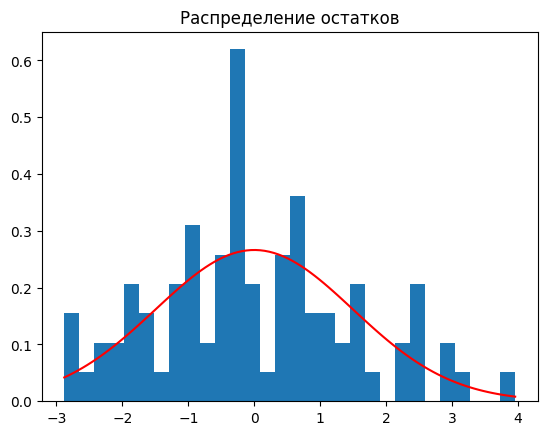

In [10]:
plt.hist(res.resid, bins=30, density=True)
plt.title("Распределение остатков")

mu, std = np.mean(res.resid), np.std(res.resid)

x = np.linspace(min(res.resid), max(res.resid), 100)

p = norm.pdf(x, mu, std)

plt.plot(x, p, 'r')
plt.show()

#### Проверяем гипотезы о нормальном характере распределения регрессионных остатков 

In [11]:
ks_test = stats.kstest(res.resid, 'norm', args=(np.mean(res.resid), np.std(res.resid, ddof=1)))
p = 0.05
ks_test.pvalue

print("Регрессионные остатки принадлежат нормальному распределнию" if ks_test.pvalue > p else "Регрессионные остатки не принадлежат нормальному распределнию")

Регрессионные остатки принадлежат нормальному распределнию


#### Cтроеним доверительные интервалы для значимых коэффициентов

In [12]:
signif = results_st[results_st['Значимость'] == 'значим']
x_signif = signif['Коэффициент'].values  

conf_int = res.conf_int().loc[x_signif]

for var, (lower, upper) in zip(conf_int.index, conf_int.values):    
    lower_rounded = round(lower, 4)
    upper_rounded = round(upper, 4)
    
    if var == 'const':
        print(f"{lower_rounded} < b0 < {upper_rounded}")
    else:
        coef_num = var[1:] 
        print(f"{lower_rounded} < b{coef_num} < {upper_rounded}")

54.906 < b0 < 81.6005
0.0013 < b1 < 0.0035
-0.4587 < b5 < -0.1539
0.0349 < b7 < 0.0708
-0.004 < b8 < -0.0001


#### Проанализируем оценку матрицы парных коэффициентов корреляции между объясняющими переменными (для обнаружения мультиколлениарности)

In [19]:
numeric_data = data[data.columns[2:]]
numeric_data

,X1,X2,X3,X4,X5,X6,X7,X8
0,780,28083,67.3,103.3,13.3,28.4,104.42,1041.5
1,837,40104,66.9,99.9,11.8,28.1,107.54,885.8
2,727,43161,72.0,105.9,9.0,34.2,108.79,1127.1
3,1006,29728,66.2,103.7,12.0,27.9,119.02,702.1
4,629,35281,77.8,105.2,5.6,36.0,140.00,766.2
...,...,...,...,...,...,...,...,...
80,2413,25262,66.1,111.9,17.4,21.2,179.03,428.3
81,682,25976,73.2,112.1,13.0,31.7,124.23,861.8
82,77,45215,76.1,107.5,5.2,25.0,74.23,1259.1
83,795,56231,82.4,113.0,3.6,22.3,125.14,1428.9


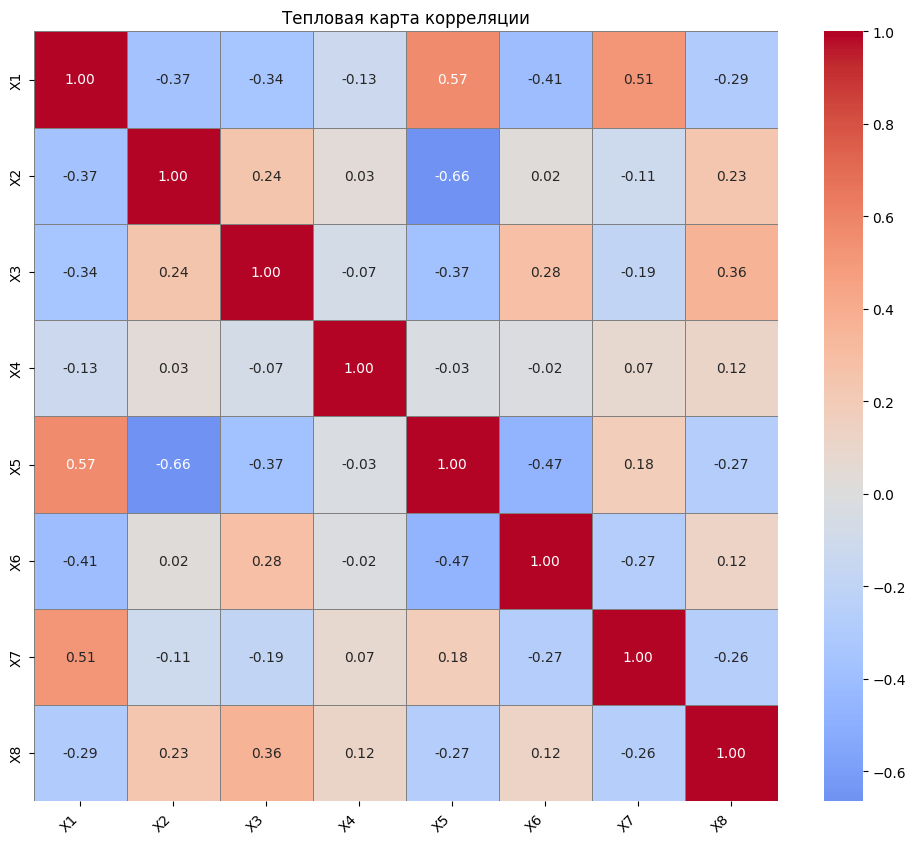

In [20]:
plt.figure(figsize=(12, 10))
corr_matrix = numeric_data.corr()

heatmap = sns.heatmap(corr_matrix, 
                     annot=True, 
                     fmt=".2f", 
                     cmap='coolwarm', 
                     center=0,
                     linewidths=0.5,
                     linecolor='gray')

plt.title('Тепловая карта корреляции')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

plt.show()

#### Наличие значимых коэффициентов корреляции, по абсолютной величине превосходящих 0,6, свидетельствует о присутствии мультиколлинеарности

In [21]:
alpha = 0.6
multicol = (corr_matrix.abs() > alpha) & (corr_matrix < 1)

print("Мультиколлениарность:")
print(corr_matrix[multicol].stack())

Мультиколлениарность:
X2  X5   -0.664965
X5  X2   -0.664965
dtype: float64


#### Рассчитаем значения коэффициентов детерминации каждой из объясняющих переменных по всем остальным переменным

In [22]:
r_2 = {}

for col in X.columns:
    target_x = X[col]  
    other_x = X.drop(columns=[col])  
    other_x = sm.add_constant(other_x)  
    
    model_r2 = sm.OLS(target_x, other_x).fit()  
    r_2[col] = model_r2.rsquared 

for var, r2 in r_2.items():
    print(f"R² для {var} на основе остальных переменных: {r2:.4f}")

R² для const на основе остальных переменных: -inf
R² для X1 на основе остальных переменных: 0.5343
R² для X2 на основе остальных переменных: 0.5576
R² для X3 на основе остальных переменных: 0.2501
R² для X4 на основе остальных переменных: 0.0830
R² для X5 на основе остальных переменных: 0.6968
R² для X6 на основе остальных переменных: 0.4237
R² для X7 на основе остальных переменных: 0.3385
R² для X8 на основе остальных переменных: 0.2106


C:\Users\79814\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [23]:
multicol_r2 = {var: r2 for var, r2 in r_2.items() if r2 > 0.55}

vars_str = ", ".join(multicol_r2.keys()) 
print(f"Анализ коэффициентов детерминации показал наличие сильной линейной связи между переменными {vars_str} и всеми остальными признаками")

Анализ коэффициентов детерминации показал наличие сильной линейной связи между переменными X2, X5 и всеми остальными признаками


#### Устранение мультиколлениарности методом пошаговой регрессии с включением переменных:

In [24]:
Y = data['Y'].astype(int)  

scaler = StandardScaler()
X_new = scaler.fit_transform(X)

linear_model = LogisticRegression(max_iter=1000, solver='lbfgs')

sfs = SequentialFeatureSelector(estimator=linear_model,
          k_features=4,
          forward=True,
          scoring='r2',
          cv=None)  

selected_features_forward = sfs.fit(X_new, Y)

print("Выбранные признаки:", ', '.join(f'X{i+1}' for i in selected_features_forward.k_feature_idx_))

Выбранные признаки: X1, X2, X6, X8


#### Устранение мультиколлениарности методом пошаговой регрессии с исключением переменных:

In [25]:
Y = data['Y'].astype(int)  

scaler = StandardScaler()
X_new = scaler.fit_transform(X)

linear_model = LogisticRegression(max_iter=1000, solver='lbfgs')

sfs = SequentialFeatureSelector(estimator=linear_model,
          k_features = 4,
          forward=True,
          scoring='r2',
          cv=None)  

selected_features_backward = sfs.fit(X_new, Y)

print("Выбранные признаки:", ', '.join(f'X{i+1}' for i in selected_features_backward.k_feature_idx_))

Выбранные признаки: X1, X2, X6, X8


#### После удаления признаков, вызывающих мультиколлинеарность, в данных остаются только значимые переменные.

In [28]:
new_data = data[['Y'] + list(x_signif[1:])]
new_data.head()

,Y,X1,X5,X7,X8
0,70.77,780,13.3,104.42,1041.5
1,68.25,837,11.8,107.54,885.8
2,71.54,727,9.0,108.79,1127.1
3,72.20,1006,12.0,119.02,702.1
4,73.70,629,5.6,140.00,766.2


#### Переобучаем МНК-модель на данных без мультиколлинеарности

In [29]:
X = new_data[new_data.columns[1:]]
Y = new_data['Y']
X = sm.add_constant(X)

new_model = sm.OLS(Y,X).fit()
summary = new_model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     35.46
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           5.09e-17
Time:                        21:55:45   Log-Likelihood:                -158.19
No. Observations:                  85   AIC:                             326.4
Df Residuals:                      80   BIC:                             338.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.1543      1.523     44.748      0.0

#### Строим новую оценку уравнения регрессии
##### Получили значимую регрессионную модель

In [30]:
coefficients = pd.DataFrame(new_model.params)

equation = f"Y = {coefficients.loc['const',0]:.4f}"

for name, coef in coefficients[1:].iterrows():
    x = name
    i = coef[0]
    sign = "+" if i >= 0 else "-"
    equation += f" {sign} {abs(i):.6f}*{x}"


print("Новое уравнение регрессии:")
print(equation)

Новое уравнение регрессии:
Y = 68.1543 + 0.002491*X1 - 0.269848*X5 + 0.055925*X7 - 0.002249*X8


#### Исследуем регрессионные остатки на наличие/отсутствие гетероскедастичности
##### Для этого построим графики зависимости модулей остатков от упорядоченных по возрастанию значений той объясняющей переменной, вариацией которой возможно порождается гетероскедастичность

In [31]:
residuals = np.array(abs(new_model.resid))
new_data['residuals'] = residuals 
new_data.head()

C:\Users\79814\AppData\Local\Temp\ipykernel_48532\3193652183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['residuals'] = residuals


,Y,X1,X5,X7,X8,residuals
0,70.77,780,13.3,104.42,1041.5,0.765092
1,68.25,837,11.8,107.54,885.8,2.826359
2,71.54,727,9.0,108.79,1127.1,0.454901
3,72.20,1006,12.0,119.02,702.1,0.298523
4,73.70,629,5.6,140.00,766.2,0.615742


#### По графикам видно, что модули регрессионных остатков не имеют тенденции к снижению при увеличении значений объясняющей переменной. Следовательно, нельзя заподозрить гетероскедастичность 

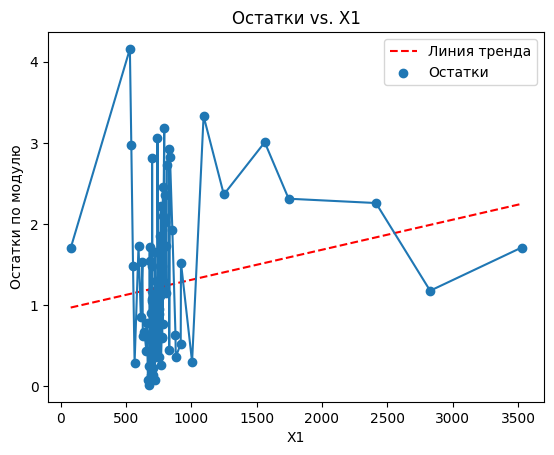

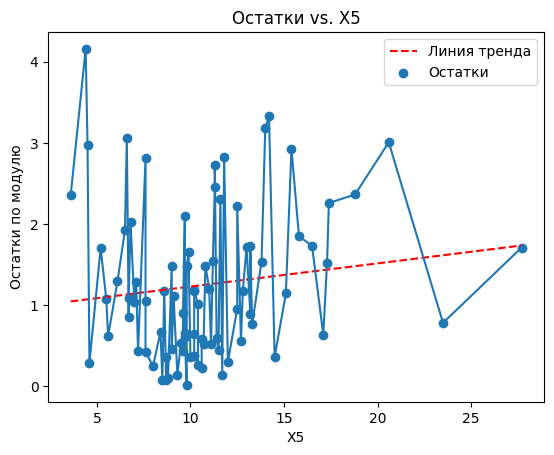

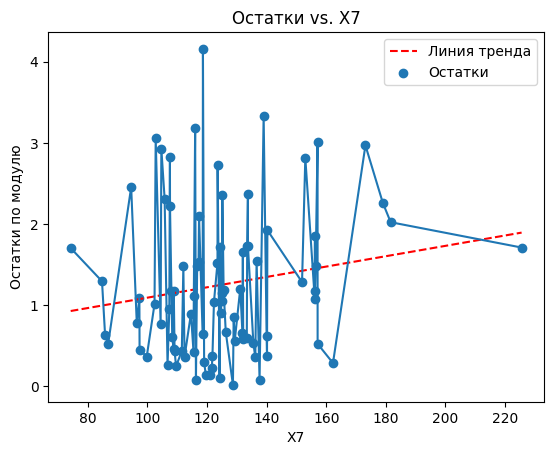

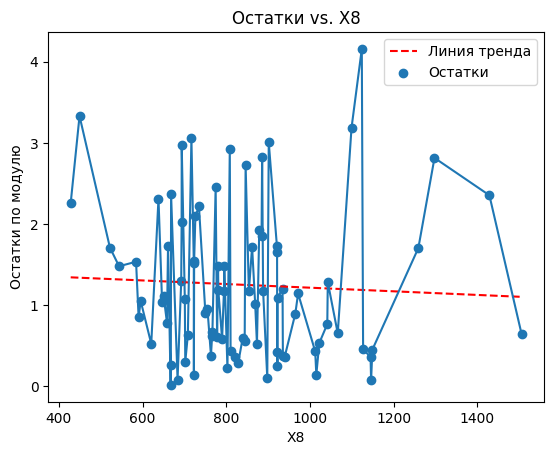

In [32]:
def graph(Xj, column_name):
   df = pd.DataFrame()
   df['Xj'] = Xj
   df['e'] = new_data['residuals']
   df = df.sort_values(by='Xj')

   z = np.polyfit(df['Xj'], df['e'], 1) 
   p = np.poly1d(z)
   plt.plot(df['Xj'], p(df['Xj']), "r--", label="Линия тренда")
   plt.scatter(df['Xj'], df['e'], label="Остатки")
   plt.xlabel(column_name)
   plt.ylabel("Остатки по модулю")
   plt.title(f"Остатки vs. {column_name}")
   plt.legend() 
   
   return(plt.plot(df['Xj'], df['e']))
   
for i in new_data.columns[1:5]:
   plt.show(graph(new_data[i], i))

#### Проведем тест ранговой корреляции Спирмена

In [33]:
# Тест Спирмена 
spearman = pd.DataFrame(columns=['rho', 'pvalue', 'hypothesis'])
alpha = 0.05

for x in new_data.columns[1:6]:
    rho, pvalue = spearmanr(new_data[x], new_data['residuals'])
    if pvalue < alpha:
        hypothesis = 'есть гетерос.'
    else:
        hypothesis = 'нет гетерос.'

    new_row = {'rho': rho, 'pvalue': pvalue, 'hypothesis': hypothesis}
    spearman = pd.concat([spearman, pd.DataFrame([new_row], index=[f'{x} & |e|'])], ignore_index=False)
 
spearman

C:\Users\79814\AppData\Local\Temp\ipykernel_48532\3067597190.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spearman = pd.concat([spearman, pd.DataFrame([new_row], index=[f'{x} & |e|'])], ignore_index=False)


,rho,pvalue,hypothesis
X1 & |e|,0.305801,0.004426,есть гетерос.
X5 & |e|,0.166632,0.127457,нет гетерос.
X7 & |e|,0.123686,0.259413,нет гетерос.
X8 & |e|,-0.127282,0.245710,нет гетерос.
residuals & |e|,1.000000,0.000000,есть гетерос.


#### Проведем тест Голдфелда-Квандта

In [34]:
# Тест Голдфелда-Квандта для X1 
def test_kvandta(df, Xj, Y):
    kvandta = pd.DataFrame()
    kvandta['Y'] = df[Y]
    kvandta['Xj'] = df[Xj]
    kvandta = kvandta.sort_values(by = 'Xj')
    n = round(3/8 * len(df))

    n1 = kvandta[:n]
    n2 = kvandta[-n:]

    X1 = sm.add_constant(n1['Xj'])
    X2 = sm.add_constant(n2['Xj'])

    model1 = sm.OLS(n1['Y'],X1).fit()
    model2 = sm.OLS(n2['Y'],X2).fit()

    rss1 = np.sum(model1.resid**2)
    rss2 = np.sum(model2.resid**2)
    fvalue = max(rss1,rss2) / min(rss1,rss2)
    
    alpha = 0.05
    df1 = model1.df_resid
    df2 = model2.df_resid
    F_critical = stats.f.ppf(1 - alpha, df2, df1)
    
    if fvalue > F_critical:
        h = 'H1: наличие гетероскедастичности' 
    else:
        h = 'H0: отсутствие гетероскедастичности'

    return (h)


print(test_kvandta(new_data, 'X1', 'Y'))

H0: отсутствие гетероскедастичности


In [35]:
# Тест Голдфелда-Квандта для X5
def test_kvandta(df, Xj, Y):
    kvandta = pd.DataFrame()
    kvandta['Y'] = df[Y]
    kvandta['Xj'] = df[Xj]
    kvandta = kvandta.sort_values(by = 'Xj')
    n = round(3/8 * len(df))

    n1 = kvandta[:n]
    n2 = kvandta[-n:]

    X1 = sm.add_constant(n1['Xj'])
    X2 = sm.add_constant(n2['Xj'])

    model1 = sm.OLS(n1['Y'],X1).fit()
    model2 = sm.OLS(n2['Y'],X2).fit()

    rss1 = np.sum(model1.resid**2)
    rss2 = np.sum(model2.resid**2)
    fvalue = max(rss1,rss2) / min(rss1,rss2)
    
    alpha = 0.05
    df1 = model1.df_resid
    df2 = model2.df_resid
    F_critical = stats.f.ppf(1 - alpha, df2, df1)
    
    if fvalue > F_critical:
        h = 'H1: наличие гетероскедастичности' 
    else:
        h = 'H0: отсутствие гетероскедастичности'

    return (h)


print(test_kvandta(new_data, 'X5', 'Y'))

H1: наличие гетероскедастичности


#### Проведем тест Глейзера

In [36]:
# Тест Глейзера для х5
gleizera  = pd.DataFrame(columns=['ϒ', 'b0', 'Sb0', 'b1', 'Sb1', 'R2', 'F'])
gamma = np.arange(-3, 3.5, 0.5)
gamma = gamma[gamma != 0]

result = []
for i in gamma:
    x = new_data['X5'] ** i 
    y = new_data['residuals']
    x = sm.add_constant(x)
    model_glz = sm.OLS(y, x).fit()

    result.append ({
        'ϒ': i,
        'b0': model_glz.params['const'], 
        'Sb0': model_glz.bse['const'],    
        'b1': model_glz.params['X5'],  
        'Sb1': model_glz.bse['X5'],  
        'R2': model_glz.rsquared,   
        'F': model_glz.fvalue,     
        'pval': model_glz.f_pvalue
    })
    
gleizera = pd.DataFrame(result)
gleizera = gleizera.round(4)
gleizera

,ϒ,b0,Sb0,b1,Sb1,R2,F,pval
0,-3.0,1.1193,0.1165,68.4823,32.2161,0.0516,4.5187,0.0365
1,-2.5,1.0974,0.1276,31.0327,16.2493,0.0421,3.6473,0.0596
2,-2.0,1.0757,0.1477,13.2216,8.2473,0.0300,2.5700,0.1127
3,-1.5,1.0599,0.1868,5.1672,4.2837,0.0172,1.4551,0.2311
4,-1.0,1.0634,0.2733,1.7487,2.3834,0.0064,0.5383,0.4652
5,-0.5,1.1341,0.5454,0.3601,1.6715,0.0006,0.0464,0.8299
6,0.5,0.8219,0.5594,0.1325,0.1704,0.0072,0.6044,0.4391
7,1.0,0.9414,0.2851,0.0286,0.0248,0.0158,1.3359,0.2511
8,1.5,1.0124,0.1958,0.0064,0.0045,0.0234,1.9916,0.1619
9,2.0,1.0695,0.1541,0.0014,0.0009,0.0278,2.3711,0.1274


In [37]:
heteroskedasticity = any(pval < 0.05 for pval in gleizera['pval'])
print('Есть гетероскедастичность' if heteroskedasticity else 'Нет гетероскедастичности')

Есть гетероскедастичность


#### Найдем ОМНК-оценки коэффициентов уравнения регрессии для построения ОЛММР

In [2]:
# Оценки bomnk и Sbj

def bomnk(file): 
    X = file.iloc[:, 1:5] 
    Y = file.iloc[:, 0]  
    n = len(Y)

    X1 = np.diag(1 / file['X1']**2)
    XJ = sm.add_constant(X)
    XJ_np = XJ.to_numpy()
    Y_np = Y.to_numpy().reshape(-1, 1)
    
    # bomnk
    part1 = np.linalg.inv(XJ_np.T @ np.linalg.inv(X1) @ XJ_np)
    part2 = XJ_np.T @ np.linalg.inv(X1) @ Y_np
    b = np.dot(part1, part2)
    b_df = pd.DataFrame(b, index=['const', 'X1','X5','X7', 'X8'], columns=['b'])

    # Sbj
    fgh = Y_np - XJ_np @ b 
    Somnk = np.sqrt((fgh.T @ np.linalg.inv(X1) @ fgh) / (n - XJ_np.shape[1] - 1))
    XT_invX_X = np.linalg.inv(XJ_np.T @ np.linalg.inv(X1) @ XJ_np)
    Sbj = pd.DataFrame(np.sqrt(np.diag(Somnk[0,0]**2 * XT_invX_X)), columns=['Sbj'], index=['const', 'X1','X5','X7', 'X8'])

    res = b_df.join(Sbj)
    return res

b_table = bomnk(new_data)
b_table

NameError: name 'new_data' is not defined

#### Построение обобщенной линейной модели множественной регрессии

In [1]:
new_equation = f"Y = {b_table.iloc[0,0]:.4f}"

for i in range(1,5):
    x = b_table.index[i]
    coeff = b_table.iloc[i,0]
    sign = "+" if coeff >= 0 else "-"
    new_equation += f" {sign} {abs(coeff):.6f}*{x}"


print("Уравнение регрессии:")
print(new_equation)

NameError: name 'b_table' is not defined

#### Проверим модель на автокорреляцию

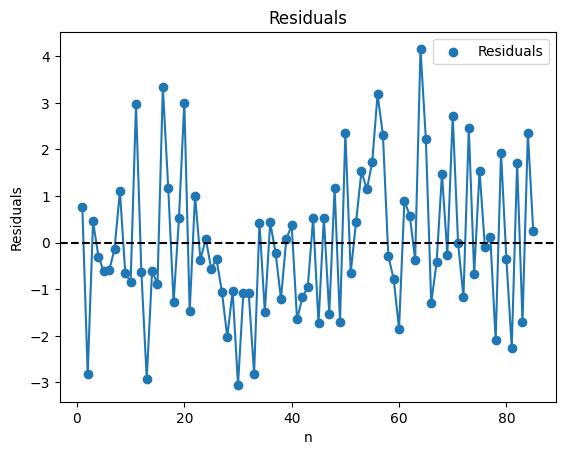

In [41]:
x_oxis = np.arange(1,86)
y_oxis = new_model.resid
plt.plot(x_oxis,y_oxis)
plt.axhline(y=0, color='black', linestyle='--')
plt.scatter(x_oxis, y_oxis, label="Residuals")   
plt.xlabel('n')
plt.ylabel("Residuals")
plt.title(f"Residuals")
plt.legend()

In [42]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(new_model.resid)
if dw_statistic < 1.5:
    print("Обнаружена положительная автокорреляция.")
elif dw_statistic > 2.5:
    print("Обнаружена отрицательная автокорреляция.")
else:
    print("Автокорреляция не обнаружена.")

Автокорреляция не обнаружена.


### Вывод: проведенный анализ позволил построить адекватную, статистически значимую эконометрическую модель, оценивающую зависимость продолжительности жизни граждан от выбранных факторов. Отсутствие автокорреляции, мультиколлинеарности и гетероскедастичности подтверждает надежность и состоятельность полученных оценок коэффициентов.